<a href="https://colab.research.google.com/github/krystaldowling/MAST30034_Final_Project-/blob/LSTM/LSTM_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Bidirectional
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Data/final_preproccessed_data.csv', lineterminator='\n')

In [ ]:
# tokenise data

def tokeniser(data, max_len=500):
# maximum length of the vectors is 500

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data['text'])
  # dictonary of all words in data and counts
  word_index = tokenizer.word_index
  # number of words in all articles in dataset
  vocab_size = len(word_index)
  sequences = tokenizer.texts_to_sequences(data['text'])
  # padding data
  padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

  return padded, vocab_size, word_index, tokenizer

padded, vocab_size, word_index, tokenizer = tokeniser(data)

In [ ]:
# split data into test and train sets

X_train, X_test, y_train, y_test =  sklearn.model_selection.train_test_split(padded, data['label'],test_size = 0.2, random_state = 20)

In [ ]:
# trained GloVe embeddings sourced from https://nlp.stanford.edu/projects/glove/

EMBEDDING_FILE = '/content/drive/My Drive/glove.6B/glove.6B.100d.txt'

# the following code has been modified from Rama Vish, October 2020, https://www.kaggle.com/raamav/useful-functions-for-text-processing-v2

# get the word coefficients from file
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

# create embedding matrix 
embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size+1, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector;


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
# the best - performing LSTM-CNN model

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    # 1 x 5 filter for the convolutional layer
    tf.keras.layers.Conv1D(32, 5, activation='relu',padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.2),
    # 1 x 3 filter for the convolutional layer
    tf.keras.layers.Conv1D(64, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

# important to note that default shuffle is set to true so the NN doesn't memorise a sequence and increases generability
history = model_lstm.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))

#plot_model(model_lstm, show_shapes=True, to_file='/content/drive/My Drive/Data/model.png')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 100)         23440100  
_________________________________________________________________
dropout_47 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          16032     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
dropout_48 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 64)        

In [ ]:
# base LSTM model - no convolutional layers 
model_base_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model_base_lstm.summary())

model_base_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# important to note that default shuffle is set to true so the NN doesn't memorise a sequence and increases generability
history = model_base_lstm.fit(X_train, y_train, epochs=200, batch_size=50, validation_data=(X_test, y_test), 
                              callbacks=tf.keras.callbacks.EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=10, 
                                  verbose=0, mode='auto',baseline=None, 
                                  restore_best_weights=False
                                  )
                              )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         23440100  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          9680      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [ ]:
# getting average results for base lstm model

results_base_mod = {}

val_acc = []
val_loss = []

for i in range(5):
    # base LSTM model - no convolutional layers 
    model_base_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.LSTM(20, return_sequences=True),
        #tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dropout(0.2),  
        tf.keras.layers.Dense(256),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

    model_base_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    # important to note that default shuffle is set to true so the NN doesn't memorise a sequence and increases generability
    history = model_base_lstm.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))

    m = max(history.history['val_accuracy'])

    results_base_mod.append((history.history['val_accuracy'].index(m),m))

print("Training Complete")

Epoch 1/30
472/472 [==============================] - 19s 41ms/step - loss: 0.6530 - accuracy: 0.5929 - val_loss: 0.6254 - val_accuracy: 0.6068
Epoch 2/30
472/472 [==============================] - 18s 39ms/step - loss: 0.6277 - accuracy: 0.6198 - val_loss: 0.6632 - val_accuracy: 0.5899
Epoch 3/30
211/472 [============>.................] - ETA: 9s - loss: 0.6369 - accuracy: 0.6208

KeyboardInterrupt: ignored

In [ ]:
# getting average results for best model

results = {}

val_acc = []
val_loss = []

for i in range(10):
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),
        # 1 x 5 filter for the convolutional layer as each sample is a vector
        tf.keras.layers.Conv1D(32, 5, activation='relu',padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 3, activation='relu',padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dropout(0.2),  
        tf.keras.layers.Dense(256),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    # important to note that default shuffle is set to true so the NN doesn't memorise a sequence and increases generability
    history = model_lstm.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))

    m = max(history.history['val_accuracy'])

    results.append((history.history['val_accuracy'].index(m),m))

print("Training Complete")

In [ ]:
 # code modified from https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

def calc_metrics(model,X_test,y_test):

    # predict probabilities for test set
    yhat_probs = model.predict(X_test, verbose=0)
    # predict crisp classes for test set
    yhat_classes = model.predict_classes(X_test, verbose=0)
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)

    return accuracy, precision, recall, f1

In [ ]:
accuracy, precision, recall, f1 = calc_metrics(model_base_lstm,X_test,y_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.896236
Precision: 0.896125
Recall: 0.857932
F1 score: 0.876613


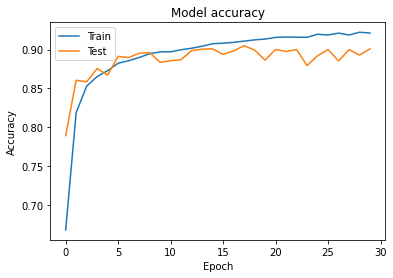

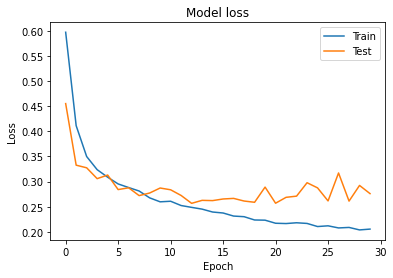

In [ ]:

# Visualize the results:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
